# Analyze `2 Gene` simulation coupling performance

Asses the coupling accuracy over `2-gene` simulations using the setting presented by [[FS-21]](https://www.nature.com/articles/s41467-021-25133-1).



# Preliminaries

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils_ot import (
    fit_seeds,
    plot_trajectory,
    simulate_data,
    anndata_from_sim,
    plot_metrics,
    method_colors,
)

import pickle
import moscot

In [2]:
moscot.__version__

'0.3.4.dev158+gee31deb'

In [3]:
import warnings

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Dependencies

We provide scripts which can be run on a SLURM based cluster scheduling system and output.

Running the scripts will: 
1. Produce simulated trajectories of types: "bifurcation", "convergent", "partial_convergent", and "mismatched_clusters"  using LineageOT by ([[FS-21]](https://www.nature.com/articles/s41467-021-25133-1)).
2. Compute the couplings using:
    1. LineageOT
    2. OT
    3. GW
    4. moslin
3. Evaluate coupling accuracy.

The output of this analysis is saved under `DATA_DIR`. In this notebook we use the `.csv` files `"{flow_type}_res_seeds.csv"`. 

To run the pipeline modify paths within `run.sh` to activate local environment and call:  `python3 run_sbatch.py`

## Set up paths

Define the paths for data and figures

In [4]:
sys.path.insert(
    0, "../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "simulations/forrow_2gene"
DATA_DIR = DATA_DIR / "simulations/forrow_2gene"

plt.rcParams["figure.figsize"] = [1, 1]

## Set global parameters

In [5]:
flow_types = ["bifurcation", "convergent", "partial_convergent", "mismatched_clusters"]
save = False

# Visualize sample trajectories

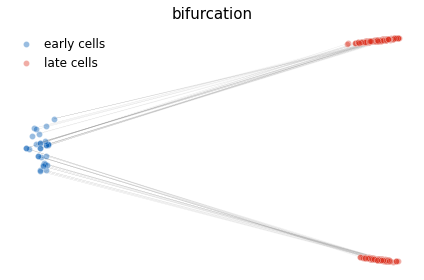

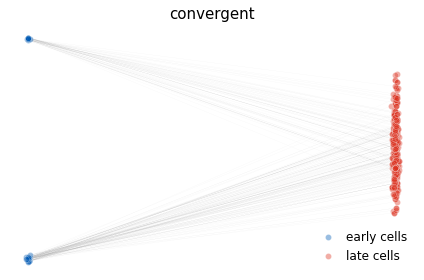

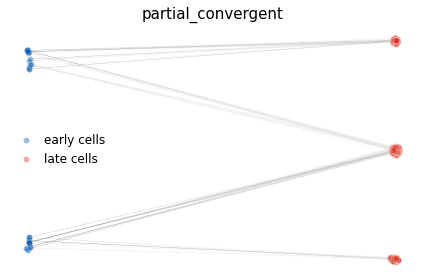

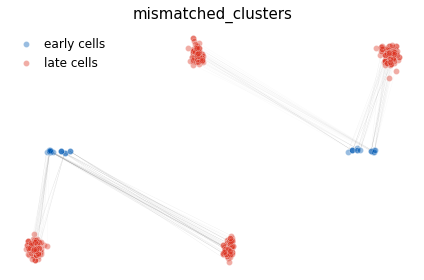

In [6]:
seed = 4698

for flow_type in flow_types:
    sim = simulate_data(flow_type, seed=seed)
    s, t = plot_trajectory(
        sim,
        flow_type=flow_type,
        savefig=save,
        subsample=True,
        alpha_scale=0.1,
        linewidth=0.2,
        legend_off=False,
    )

In [7]:
flow_type = "bifurcation"
sim = simulate_data(flow_type, seed=seed)
adata = anndata_from_sim(sim, flow_type=flow_type)

### Plot sample cost matrices

In [8]:
cmat = adata.obsp["cost_matrices_true"] / np.max(adata.obsp["cost_matrices_true"])
cmat[cmat == 0] = np.nan
np.fill_diagonal(cmat, 0)

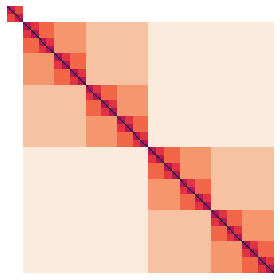

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
sns.heatmap(
    cmat,
    xticklabels=[],
    yticklabels=[],
    cbar=False,
    ax=axs,
)

plt.tight_layout()
if save:
    plt.savefig(
        FIG_DIR / f"{flow_type}_cost_true.png",
        bbox_inches="tight",
        transparent=True,
        dpi=300,
    )
plt.show()

# Import simulation results

In [10]:
flow_types = ['bifurcation', 'convergent', 'mismatched_clusters',  "partial_convergent"]

In [11]:
dfs = {}
for flow_type in flow_types:
    print(f"importing results of {flow_type}.")
    dfs[flow_type] = pd.read_csv(DATA_DIR / f"{flow_type}_res_seeds.csv")

importing results of bifurcation.
importing results of convergent.
importing results of mismatched_clusters.
importing results of partial_convergent.


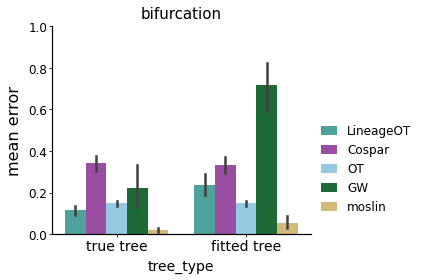

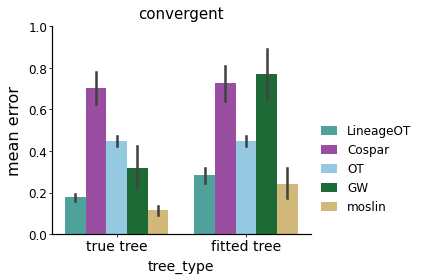

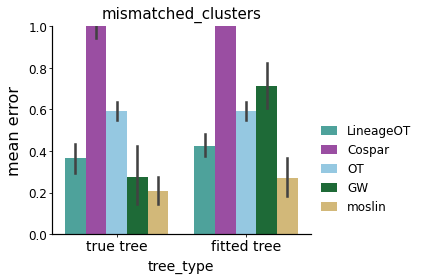

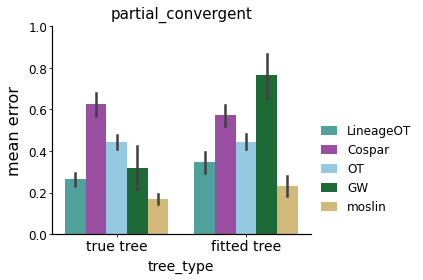

In [12]:
hue_order = ['LineageOT', 'Cospar', 'OT', 'GW', 'moslin']
save = False
for flow_type, df in dfs.items():
    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    sns.barplot(
        data=df,
        x="tree_type",
        y="mean_error",
        hue="method",
        hue_order=hue_order,
        palette=method_colors,
        ax=axs,
    )
    axs.set_xticklabels(["true tree", "fitted tree"], fontsize=14)
    axs.set_ylabel("mean error", fontsize=16)
    axs.set_ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
    plt.title(flow_type)
    plt.tight_layout()
    if save:
        plt.savefig(
            FIG_DIR / f"{flow_type}_bar.pdf",
            bbox_inches="tight",
            dpi=300,
        )
    plt.show()

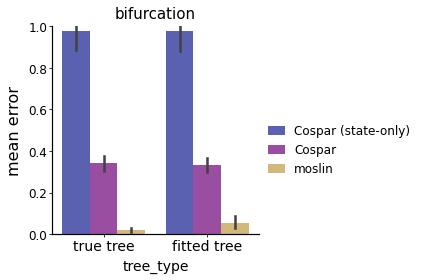

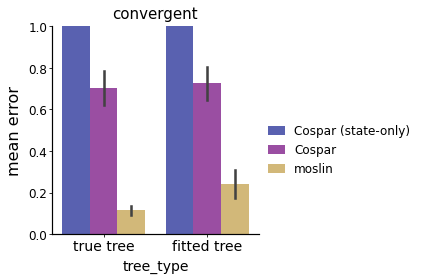

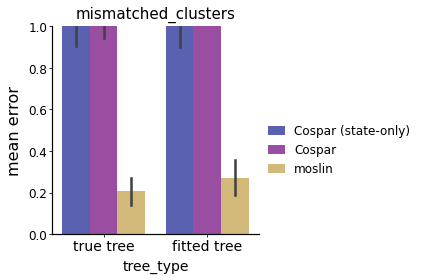

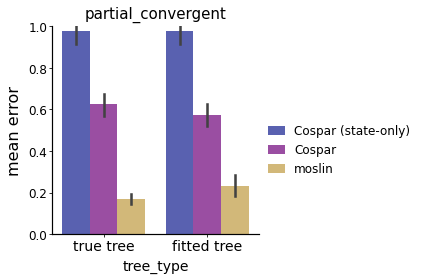

In [13]:
hue_order = ["Cospar (state-only)", "Cospar",  "moslin"]
save = False
for flow_type, df in dfs.items():
    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    sns.barplot(
        data=df,
        x="tree_type",
        y="mean_error",
        hue="method",
        hue_order=hue_order,
        palette=method_colors,
        ax=axs,
    )
    axs.set_xticklabels(["true tree", "fitted tree"], fontsize=14)
    axs.set_ylabel("mean error", fontsize=16)
    axs.set_ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
    plt.title(flow_type)
    plt.tight_layout()
    if save:
        plt.savefig(
            FIG_DIR / f"{flow_type}_bar_cospar.pdf",
            bbox_inches="tight",
            dpi=300,
        )
    plt.show()

In [14]:
dfm = {}
diffs_true_lot = []
diffs_fitted_lot = []
diffs_true_cs = []
diffs_fitted_cs = []
for flow_type, df in dfs.items():
    dfm[flow_type] = (
        df.groupby(["method", "tree_type"]).mean(["mean_error"]).reset_index()
    )
    val_lineageot = dfm[flow_type][dfm[flow_type]["method"] == "LineageOT"][
        "mean_error"
    ]
    val_cospar = dfm[flow_type][dfm[flow_type]["method"] == "Cospar"]["mean_error"]
    val_moslin = dfm[flow_type][dfm[flow_type]["method"] == "moslin"]["mean_error"]

    
    
    diff_lot = val_lineageot.values - val_moslin.values
    diff_cs = val_cospar.values - val_moslin.values
    diffs_fitted_lot.append(diff_lot[0])
    diffs_true_lot.append(diff_lot[1])
    
    diffs_fitted_cs.append(diff_cs[0])
    diffs_true_cs.append(diff_cs[1])

    
    print(f"for {flow_type}:")
    print("lineageOT")
    print(val_lineageot.values)
    print("Cospar")
    print(val_cospar.values)
    print("moslin")
    print(val_moslin.values)
    print("diff - lot")
    print(val_lineageot.values - val_moslin.values)
    print("diff - cospar")
    print(val_cospar.values - val_moslin.values)
    

for bifurcation:
lineageOT
[0.23730316 0.11583587]
Cospar
[0.33120204 0.34089673]
moslin
[0.05528364 0.0191799 ]
diff - lot
[0.18201951 0.09665597]
diff - cospar
[0.27591839 0.32171683]
for convergent:
lineageOT
[0.2823862  0.17614619]
Cospar
[0.72663829 0.70368848]
moslin
[0.24027659 0.11466664]
diff - lot
[0.04210961 0.06147955]
diff - cospar
[0.4863617  0.58902184]
for mismatched_clusters:
lineageOT
[0.42503606 0.36472465]
Cospar
[1.24199317 1.09549859]
moslin
[0.27091559 0.20876689]
diff - lot
[0.15412047 0.15595776]
diff - cospar
[0.97107758 0.8867317 ]
for partial_convergent:
lineageOT
[0.34458883 0.26373505]
Cospar
[0.57192651 0.62405258]
moslin
[0.23089064 0.16831287]
diff - lot
[0.11369819 0.09542218]
diff - cospar
[0.34103588 0.45573971]


In [15]:
np.mean(diffs_fitted_cs)

0.5185983880943545

In [16]:
np.mean(diffs_true_cs)

0.5633025204362254

In [17]:
np.mean(diffs_fitted_lot)

0.12298694578571043

In [18]:
np.mean(diffs_true_lot)

0.10237886559503552

# Plot fit results

In [19]:
flow_type = "bifurcation"
seed = 4698

In [20]:
with open(DATA_DIR / f"{flow_type}_ancestor_errors_moslin.pkl", "rb") as fin:
    ancestor_errors_moslin = pickle.load(fin)
with open(DATA_DIR / f"{flow_type}_descendant_errors_moslin.pkl", "rb") as fin:
    descendant_errors_moslin = pickle.load(fin)


with open(DATA_DIR / f"{flow_type}_ancestor_errors_ot.pkl", "rb") as fin:
    ancestor_errors_ot = pickle.load(fin)
with open(DATA_DIR / f"{flow_type}_descendant_errors_ot.pkl", "rb") as fin:
    descendant_errors_ot = pickle.load(fin)

In [21]:
ancestor_errors_ot[seed][0]

[0.00022758459260747887,
 0.0005179474679231213,
 0.0011787686347935866,
 0.002682695795279727,
 0.006105402296585327,
 0.013894954943731374,
 0.03162277660168379,
 0.07196856730011521,
 0.16378937069540647,
 0.3727593720314942,
 0.8483428982440726,
 1.9306977288832496,
 4.393970560760795,
 10.0]

In [22]:
descendant_errors_moslin[seed]["true"][0.1]

[[0.002682695795279727,
  0.006105402296585327,
  0.013894954943731374,
  0.03162277660168379,
  0.07196856730011521,
  0.16378937069540647,
  0.3727593720314942,
  0.8483428982440726,
  1.9306977288832496,
  4.393970560760795,
  10.0],
 [0.0013357893928819665,
  0.0014143916236185388,
  0.00575034716757113,
  0.021569073636036894,
  0.04349374882705375,
  0.08183240260896141,
  0.20866574779282934,
  0.4707134860055547,
  0.7281776940123246,
  0.8763017907068434,
  0.9453515611270648]]

In [23]:
mean_err = {}
for key in ["true", "fitted"]:
    mean_err[key] = {}
    mean_err[key][0] = [
            ancestor_errors_ot[seed][0],
            [
                sum(x) / 2
                for x in zip(
                    ancestor_errors_ot[seed][1],
                    descendant_errors_ot[seed][1],
                )
            ],
        ]
    for key_val in ancestor_errors_moslin[seed][key]:
        mean_err[key][key_val] = [
            ancestor_errors_moslin[seed][key][key_val][0],
            [
                sum(x) / 2
                for x in zip(
                    ancestor_errors_moslin[seed][key][key_val][1],
                    descendant_errors_moslin[seed][key][key_val][1],
                )
            ],
        ]

In [24]:
keys_lim = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

In [25]:
mean_err_lim = {}
for key in ["true", "fitted"]:
    mean_err_lim[key] = {}
    mean_err_lim[key][0] = [
        ancestor_errors_ot[seed][0],
        [
            sum(x) / 2
            for x in zip(ancestor_errors_ot[seed][1], descendant_errors_ot[seed][1])
        ],
    ]
    for key_val in ancestor_errors_moslin[seed][key]:
        if key_val in keys_lim:
            mean_err_lim[key][key_val] = [
                ancestor_errors_moslin[seed][key][key_val][0],
                [
                    sum(x) / 2
                    for x in zip(
                        ancestor_errors_moslin[seed][key][key_val][1],
                        descendant_errors_moslin[seed][key][key_val][1],
                    )
                ],
            ]

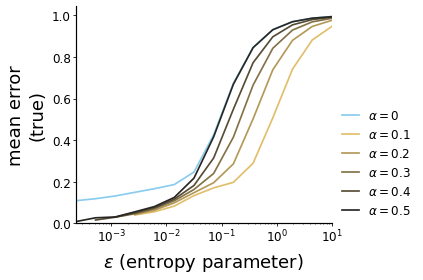

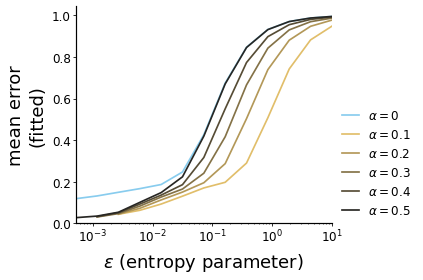

In [26]:
label_font_size=18
tick_font_size=12
pal_dict = None

for key in ["true", "fitted"]:
    ys_dict = mean_err_lim[key]
    cost_func_name=f"mean error\n({key})"
    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    pal = sns.dark_palette(method_colors["moslin"], n_colors=len(ys_dict)-1, reverse=False) 
    pal.append(method_colors["OT"])
    pal_dict = (
            pal_dict
            if pal_dict is not None
            else {val: pal[-(i+1)] for i, val in enumerate(ys_dict)}
    )
    for label, ys in ys_dict.items():
        c = pal_dict[label]
        sns.lineplot(x=ys[0], y=ys[1], label=r"$\alpha=$" + f"{label}", color=c, ax=axs)
    
    plt.ylabel(cost_func_name, fontsize=label_font_size)
    plt.xlabel(r"$\epsilon$" + " (entropy parameter)", fontsize=label_font_size)
    plt.xscale("log")
    
    plt.xticks(fontsize=tick_font_size)
    plt.yticks(fontsize=tick_font_size)
    
    plt.xlim([ys[0][0], ys[0][-1]])
    
    ylims = plt.ylim([0, None])
        # upper limit should be at least 1
    plt.ylim([0, max(ylims[1], 1)])
    ncols = 2 if len(ys_dict) > 6 else 1
    plt.legend(
            bbox_to_anchor=(1.02, 0.55),
            loc="upper left",
            borderaxespad=0,
            fontsize=tick_font_size,
            ncols=ncols,
        )
    plt.tight_layout()
    plt.savefig(
                FIG_DIR / f"{flow_type}_{key}_alpha_robust.pdf",
                bbox_inches="tight",
                dpi=300,
            )
    plt.show()

# References

[[FS-21] Forrow, A., & Schiebinger, G. LineageOT is a unified framework for lineage tracing and trajectory inference. Nature communications, 12(1), 4940.](https://www.nature.com/articles/s41467-021-25133-1)